# Opinion detector

**Participants:**
- Roger Baiges Trilla
- Adrià Cantarero Carreras

**Subject:**
- Processament del Llenguatge Humà

**Course:** 2024

**Degree:** Intel·ligència Artificial


## IMPORTS

In [1]:
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string

Necessary functions in order to avoid warnings on MacOS

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in cast")

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Downloading the necessary dataset and tools

In [4]:
# Ensure we have the necessary datasets and tools from NLTK
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## PREPROCESSING THE DATASET

In [5]:
# Create a list with all the reviews and their respective categories

documents = [(list(mr.words(fileid)), category)
             for category in mr.categories()
             for fileid in mr.fileids(category)]
data = [' '.join(words) for words, _ in documents]
labels = [category for _, category in documents]

# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# SUPERVISED MODELS

In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define the stopwords list
stop_words = set(stopwords.words('english'))

# Extending the stopwords list with movie-related words
movie_related_stopwords = [
    'movie', 'film', 'cinema', 'actor', 'actress', 'director', 'scene', 'screen', 'dvd', 'blu-ray', 
    'hollywood', 'plot', 'story', 'character', 'characters', 'storyline', 'cinematography', 'production', 
    'performances', 'cast', 'role', 'roles', 'dialogue', 'narrative', 'franchise', 'sequel', 'prequel', 
    'soundtrack', 'score', 'genre', 'genres', 'trailer', 'trailers', 'review', 'reviews', 'viewer', 
    'viewers', 'audience', 'critic', 'critics', 'acting', 'screenplay', 'visual', 'effects', 'cgi', 
    'theme', 'themes', 'setting', 'shot', 'shots', 'angle', 'angles', 'lighting', 'edit', 'edits', 
    'editing', 'version', 'versions', 'adaptation', 'series', 'sequels', 'prequels', 'installment', 
    'installments', 'chapter', 'chapters', 'release', 'releases', 'premiere', 'cameo', 'cameos', 'star', 
    'stars', 'starring', 'feature', 'featured', 'leads', 'supporting', 'extra', 'extras', 'portray', 
    'portrays', 'portrayed', 'portrayal', 'nominated', 'nomination', 'award', 'awards', 'win', 'wins', 
    'winner', 'losers', 'gross', 'box', 'office', 'ticket', 'budget', 'profit', 'profits', 'break', 
    'record', 'filmmaker', 'make', 'makes', 'made', 'creator', 'craft', 'shoot', 'shot', 'direct', 
    'produce', 'write', 'writes', 'edit', 'visuals', 'imagery', 'picture', 'photography', 'art', 
    'design', 'sound', 'music', 'melody', 'tune', 'background', 'style', 'classify', 'classified', 
    'classification', 'segment', 'section', 'part', 'feature', 'element', 'aspect', 'detail'
]

stop_words.update(movie_related_stopwords)

def preprocessed_data(document):
    """
    Preprocesses a given document by removing numbers, punctuation, converting to lowercase,
    tokenizing, removing stopwords, and lemmatizing the tokens.

    Parameters:
    - document (str): The document to be preprocessed.

    Returns:
    - str: The preprocessed document as a single string.
    """
    # Remove numbers
    document = re.sub(r'\d+', '', document)
    
    # Remove punctuation and convert to lowercase
    document = document.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Tokenize the document
    tokens = word_tokenize(document)
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove stopwords and lemmatize the tokens
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Combine the filtered tokens back into a single string
    return ' '.join(filtered_tokens)

# Apply the improved_preprocess function to the training and testing data
data_train_processed = [preprocessed_data(doc) for doc in X_train]
data_test_processed = [preprocessed_data(doc) for doc in X_test]


In [7]:
# Use CountVectorizer to convert data to a matrix of token counts
vectorizer = CountVectorizer(min_df=5)
data_train_processed = vectorizer.fit_transform(data_train_processed)
data_test_processed = vectorizer.transform(data_test_processed)

### INITIALIZE THE CLASSIFIERS

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# Initialize the classifiers    
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lr_clf = LogisticRegression(random_state=42)
nb_clf = MultinomialNB()

### SEARCH THE BEST HYPERPARAMETERS WITH CROSS-VALIDATION

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
}


lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'max_iter': [200, 300, 400]
}

nb_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 50.0]
}



# Map model names to their corresponding grid
param_grid_dict = {
    "Random Forest": rf_param_grid,
    "K-Nearest Neighbors": knn_param_grid,
    "SVM": svm_param_grid,
    "XGBoost": xgb_param_grid,
    "Logistic Regression": lr_param_grid,
    "Naive Bayes": nb_param_grid
}

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 


classifiers = {
    "Random Forest": (rf_clf, False),
    "K-Nearest Neighbors": (knn_clf, False),
    "SVM": (svm_clf, False),
    "XGBoost": (xgb_clf, True),
    "Logistic Regression": (lr_clf, False),
    "Naive Bayes": (nb_clf, False)
}


def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV and cross-validation.

    Parameters:
    - model: The machine learning model to tune.
    - param_grid (dict): The grid of hyperparameters to search.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - The best estimator with optimized hyperparameters.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


# Iterate over each model and tune hyperparameters
for model_name, (model, encode_target) in classifiers.items():
    # If the model requieres label encoding, encode the target labels
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train_encoded)
    else:
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train)
    
    # Update the classifiers dictionary with the best model
    classifiers[model_name] = (best_model, encode_target)


Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'max_depth': None, 'n_estimators': 200}
Best cross-validation score: 0.8337
Hyperparameter tuning for K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.5640
Hyperparameter tuning for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.8098
Hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.7993
Hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found: {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': '

### EVALUATE MODEL FUNCTION

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

def evaluate_model(model, X_train, X_test, y_train, y_test, encode_target=False):
    """
    Evaluates a given model on test data and returns evaluation metrics.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train, X_test: Training and test features.
    - y_train, y_test: Training and test labels.
    - encode_target (bool): Flag to indicate if the model is XGBoost, requiring label encoding.

    Returns:
    - Tuple of (conf_matrix, accuracy, precision, f1)
    """
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        model.fit(X_train, y_train_encoded)
        predictions_encoded = model.predict(X_test)
        predictions = encoder.inverse_transform(predictions_encoded)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)

    # Identifying mistakes
    mistakes = [(index, actual, pred) for index, (actual, pred) in enumerate(zip(y_test, predictions)) if actual != pred]

    return conf_matrix, accuracy, precision, f1, mistakes


## TRAIN THE FINAL MODELS

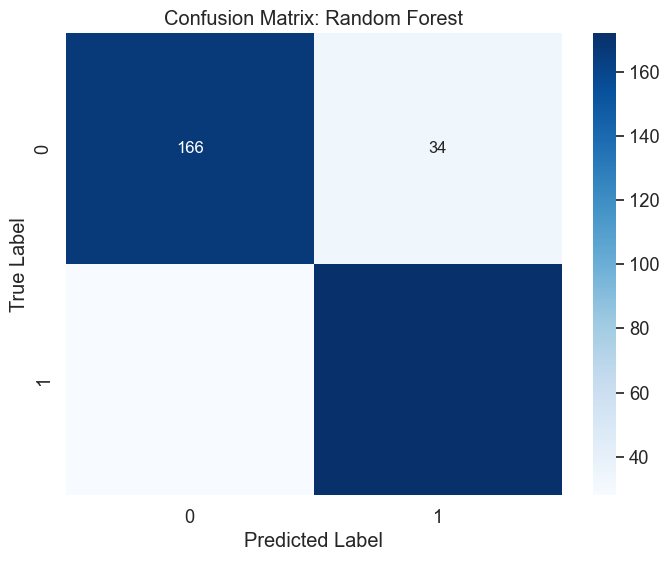

Evaluation Results for Random Forest:
Accuracy: 0.8450, Precision: 0.8453, F1 Score: 0.8450



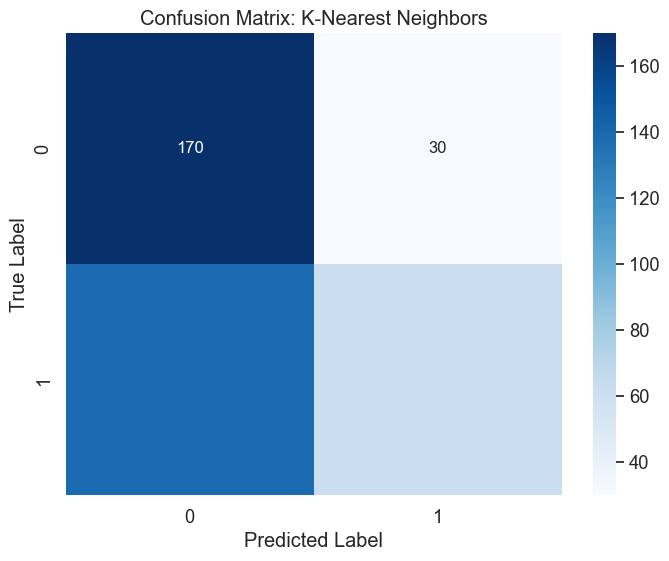

Evaluation Results for K-Nearest Neighbors:
Accuracy: 0.5800, Precision: 0.6129, F1 Score: 0.5470



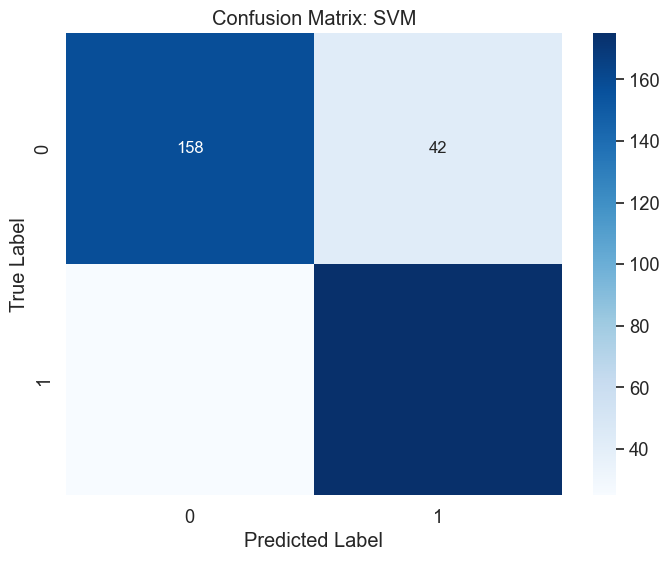

Evaluation Results for SVM:
Accuracy: 0.8325, Precision: 0.8349, F1 Score: 0.8322



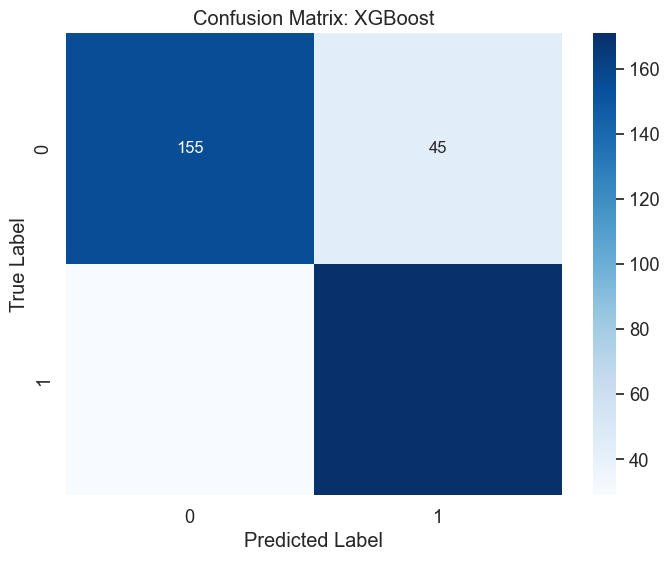

Evaluation Results for XGBoost:
Accuracy: 0.8150, Precision: 0.8170, F1 Score: 0.8147



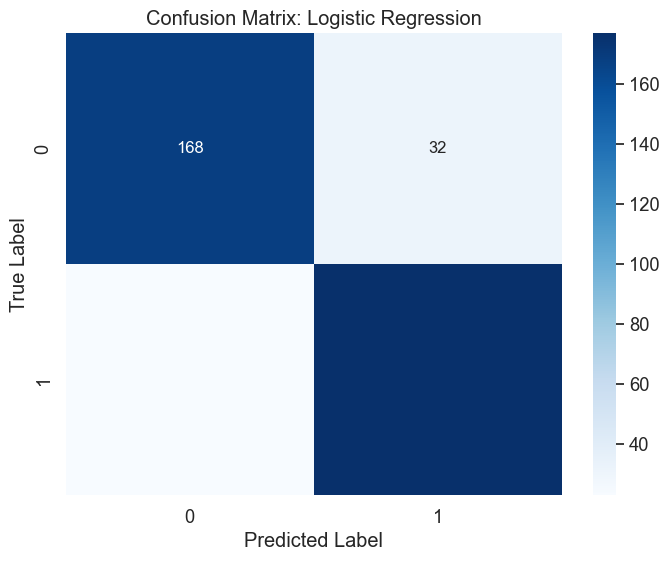

Evaluation Results for Logistic Regression:
Accuracy: 0.8625, Precision: 0.8632, F1 Score: 0.8624



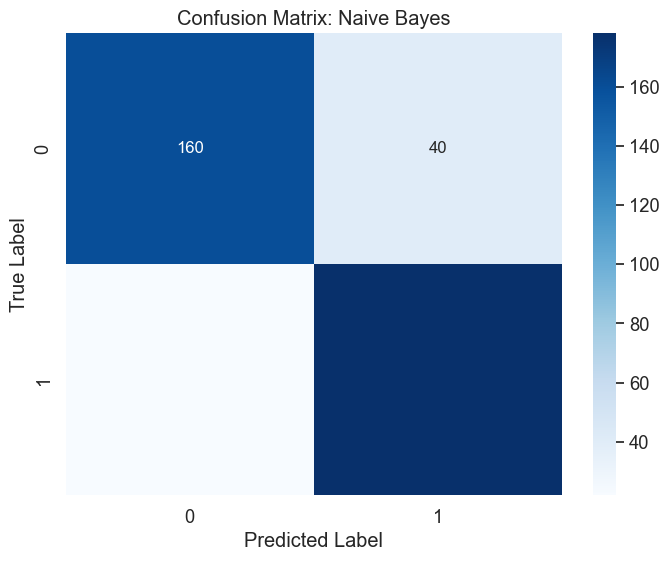

Evaluation Results for Naive Bayes:
Accuracy: 0.8450, Precision: 0.8478, F1 Score: 0.8447



In [12]:
# Iterate over each model and evaluate it on the test data

mistakes_dict = {}

for model_name, (model, encode_target) in classifiers.items():
    """
    For each model, evaluate it on the test data and display the confusion matrix.
    """
    conf_matrix, accuracy, precision, f1, mistakes = evaluate_model(model, data_train_processed, data_test_processed, y_train, y_test, encode_target)
    
    # Store the mistakes in a dictionary
    mistakes_dict[model_name] = mistakes
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt="g", xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.savefig(f'./images/confusion_matrix_{model_name}.png')
    plt.show()

    # Print evaluation metrics
    print(f"Evaluation Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}\n")

## ANALYSIS OF THE BEST MODEL

In [13]:
# Find the best model

best_model_name = max(classifiers, key=lambda x: classifiers[x][0].score(data_test_processed, y_test))
best_model = classifiers[best_model_name][0]

print(f"The best model is: {best_model_name}\n")


The best model is: Logistic Regression



### REVIEWS THAT WERE MISCLASSIFIED

In [14]:
# Display the mistakes made by the best model

print(f"Mistakes made by the best model ({best_model_name}):\n")
for mistake in mistakes_dict[best_model_name]:
    index, actual, pred = mistake
    print(f"Actual: {actual}, Predicted: {pred}")
    print(f"Review: {X_test[index]}\n")

Mistakes made by the best model (Logistic Regression):

Actual: neg, Predicted: pos
Review: running time approximately 1hr 40mins reviewed by jack choo rating : the movie starts with a rather se7en - ish opening sequence , rather cool and sets the mood for things to come . the story propels the audience into a neo - reality ; somewhat very close to conscious reality but laced with weird tinges of blue and red . existenz is actually the name of a new virtual - reality game . supposedly , vr games are highly popular as is considered a legal - drug in this neo - reality . * * * * ( leigh ) is the ultimate game creator and introduces her ultimate game - experience in the form of existenz . players are required to have bio - ports embedded in their spine , which plugs to a game - pod in order to enjoy the immersive experience . during a secretive beta - testing - cum - teaser meeting for this new game , an assassination attempt on * * * life occurs and she runs off with fellow bodyguard * *

### FUNCTION TO PREDICT THE SENTIMENT OF A GIVEN REVIEW

In [15]:
def predict_sentiment(review, model, vectorizer):
    """
    Predicts the sentiment of a given review using the best model.

    Parameters:
    - review (str): The review to predict the sentiment for.
    - model: The best model for sentiment analysis.
    - vectorizer: The CountVectorizer object used to transform the data.

    Returns:
    - str: The predicted sentiment of the review.
    """
    # Preprocess the review
    review_processed = preprocessed_data(review)
    
    # Vectorize the preprocessed review
    review_vectorized = vectorizer.transform([review_processed])
    
    # Predict the sentiment
    prediction = model.predict(review_vectorized)
    
    return prediction[0]

# Test the function with a sample review
review = "This movie was terrible! The acting was bad and the special effects were horrible."

# Positive review (very long)

sentiment = predict_sentiment(review, best_model, vectorizer)
print(f"Predicted sentiment: {sentiment}")


Predicted sentiment: neg


### FUNCTION TO PLOT THE ROC CURVE

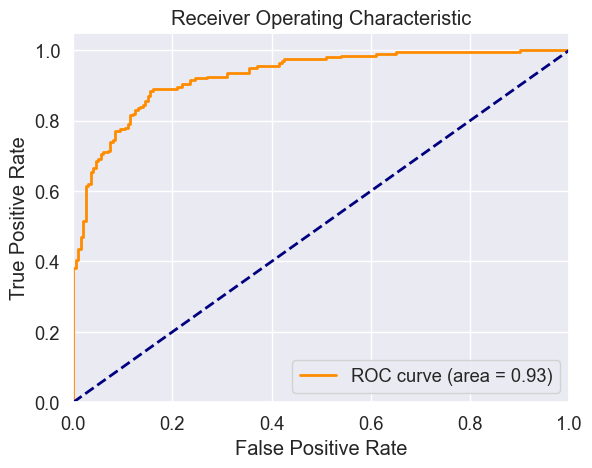

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X, y):
    """
    Plots the ROC curve of the given model without using numpy for label conversion.
    Assumes 'pos' is the positive class and 'neg' is the negative class.
    
    Parameters:
    - model: The trained model that should have a `predict_proba` method.
    - X: Feature matrix for prediction.
    - y: Actual labels, expected to be 'pos' or 'neg'.
    """
    # Preprocess labels: Convert 'pos' -> 1, 'neg' -> 0
    y_numeric = [1 if label == 'pos' else 0 for label in y]
    
    # Predict probabilities
    y_scores = model.predict_proba(X)[:, 1]  # Assuming the positive class is at index 1
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_numeric, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./images/best_model_roc_curve.png')
    plt.show()

# Plot the ROC curve for the best model
plot_roc_curve(best_model, data_test_processed, y_test)

# SENTIMENT ANALYSIS WITH SENTIWORDNET

In [38]:
print(str(X_train[0]))
print(str(X_train[1]))


it has happened again . a movie that is well scripted , well acted , and well directed . it is involving , suspenseful . . . it even has an unexpected twist at the end that packs a punch like a blow to the solar plexus . but in order to accept its premise one must also accept a spiritual lie . the sixth sense is that movie . starring bruce willis ( armageddon ) as a child psychologist and haley joel osment ( forrest gump ) as a troubled youngster , the sixth sense is more spooky than scary , though it does contain disturbing images designed to startle . eight - year - old cole sear ( osment ) sees dead people . not just in dreams . and not just as lifeless bodies . he sees them walking around like regular people . and he sees them all the time . dr . malcolm crowe ( willis ) is trying to help him . he recognizes in cole many of the same attributes as one of his earlier patients whom crowe failed , resulting in that patient shooting crowe before turning the gun on himself . if crowe cou

In [34]:
# Apliquem UKB per obtenir els synsets  https://textserver.cs.upc.edu/textserver/news
from textserver import TextServer

ts = TextServer('BaigesAndCanta', 'UKBserver-123', 'senses') 
ts.senses("L'Arnau té un gos. Se l'estima molt.")

[[["L'", 'el', 'DA0CS0', 'determiner', 'N/A'],
  ['Arnau', 'arnau', 'NP00O00', 'noun', 'N/A'],
  ['té', 'tenir', 'VMIP3S0', 'verb', '02205098-v'],
  ['un', 'un', 'DI0MS0', 'determiner', 'N/A'],
  ['gos', 'gos', 'NCMS000', 'noun', '02084071-n'],
  ['.', '.', 'Fp', 'punctuation', 'N/A']],
 [['Se', 'es', 'P00CN00', 'pronoun', 'N/A'],
  ["l'", 'el', 'PP3CSA0', 'pronoun', 'N/A'],
  ['estima', 'estimar', 'VMIP3S0', 'verb', '02256109-v'],
  ['molt', 'molt', 'RG', 'adverb', '00059171-r'],
  ['.', '.', 'Fp', 'punctuation', 'N/A']]]

In [33]:
from textserver import TextServer

ts = TextServer('BaigesAndCanta', 'UKBserver-123', 'senses')


# Creem una llista per emmagatzemar els resultats
resultats = []

# Iterem sobre cada document en X_train
for document in X_train:
    # Apliquem ts.senses al document actual
    # Asegurándonos de que 'document' es una cadena de texto
    document_str = str(document)
    senses_per_paraula = ts.senses(document_str)

    # Extraiem l'últim terme de la llista de sentits per paraula
    ultims_senses = {paraula: sentits[-1] for paraula, sentits in senses_per_paraula.items()}
    
    # Afegim els resultats a la llista de resultats
    resultats.append(ultims_senses)

# Imprimim els resultats
for i, resultat in enumerate(resultats):
    print(f"Document {i+1}: {resultat}")


HTTPError: 400 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses

In [19]:
# Obtenim els valors SentiWordnet de cada synsets
import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
# Exemple
# getting the wordnet synset
synset = wn.synset('good.a.1')
# getting the sentiwordnet synset
sentiSynset = swn.senti_synset(synset.name())
sentiSynset.pos_score(), sentiSynset.neg_score(), sentiSynset.obj_score()

ValueError: not enough values to unpack (expected 3, got 1)